In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

hexagons = gpd.read_file('../data/shapefiles/nyc/hexagons.geojson')
subway   = gpd.read_file('../data/shapefiles/subway/stops/stops_nyc_subway_may2019.shp')\
              .to_crs(hexagons.crs) # match EPSG 3627 from hexes
boros    = gpd.read_file('../data/shapefiles/nyc/boro_bounds.geojson')\
              .to_crs(hexagons.crs) # match EPSG 3627 from hexes
bikes    = pd.read_json('../data/shapefiles/nyc/bike_stations.json')

,hex_id_8,subway_station_count,geometry
1196,882a1008c7fffff,0.0,"POLYGON ((303001.618 71196.120, 303167.636 716..."
1197,882a1072c5fffff,0.0,"POLYGON ((299310.355 61667.461, 299476.186 621..."
1198,882a107213fffff,0.0,"POLYGON ((299269.196 63035.747, 298896.348 634..."


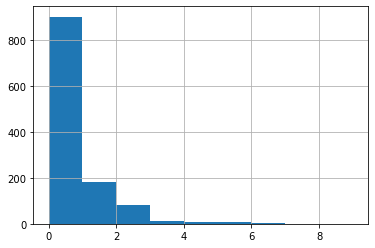

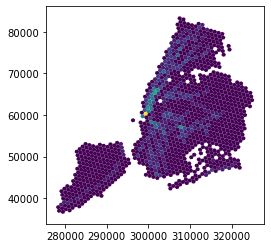

In [2]:
sjoined_polys = gpd.sjoin(hexagons, subway)

grouped_hexes = sjoined_polys.groupby('hex_id_8').size()
subway_gdf = grouped_hexes.to_frame().reset_index()
subway_gdf.columns = ['hex_id_8', 'subway_station_count']

subway_gdf = gpd.GeoDataFrame(subway_gdf.merge(hexagons, how='right'))
subway_gdf.fillna(0, inplace=True) # hexes with 0 stations should have '0' val instead of NaN

subway_gdf['subway_station_count'].hist(bins=list(range(0,10)));
subway_gdf.plot(column='subway_station_count');
subway_gdf.tail(3)

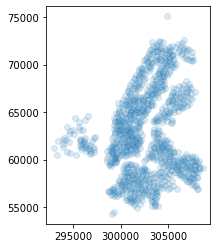

In [3]:
bike_stations = pd.DataFrame(columns=['id','lat','long'])

for station in bikes['stationBeanList'].values:
    if station['statusValue'] == 'In Service':
        new_row = {'id':station['id'],
                   'lat':station['latitude'],
                   'long':station['longitude']}
        bike_stations = bike_stations.append(new_row, ignore_index=True)
        
bike_stations = gpd.GeoDataFrame(bike_stations,
                                 geometry=gpd.points_from_xy(bike_stations['long'],
                                                             bike_stations['lat']),
                                 crs='EPSG:4326')\
                    .to_crs(hexagons.crs)

bike_stations.plot(alpha=0.15);

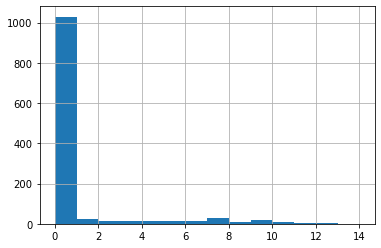

In [9]:
sjoined_polys = gpd.sjoin(hexagons, bike_stations)

grouped_hexes = sjoined_polys.groupby('hex_id_8').size()
bike_gdf = grouped_hexes.to_frame().reset_index()
bike_gdf.columns = ['hex_id_8', 'bike_station_count']

bike_gdf = gpd.GeoDataFrame(bike_gdf.merge(hexagons, how='right'))
bike_gdf.fillna(0, inplace=True) # hexes with 0 stations should have '0' val instead of NaN

bike_gdf['bike_station_count'].hist(bins=list(range(0,15)));


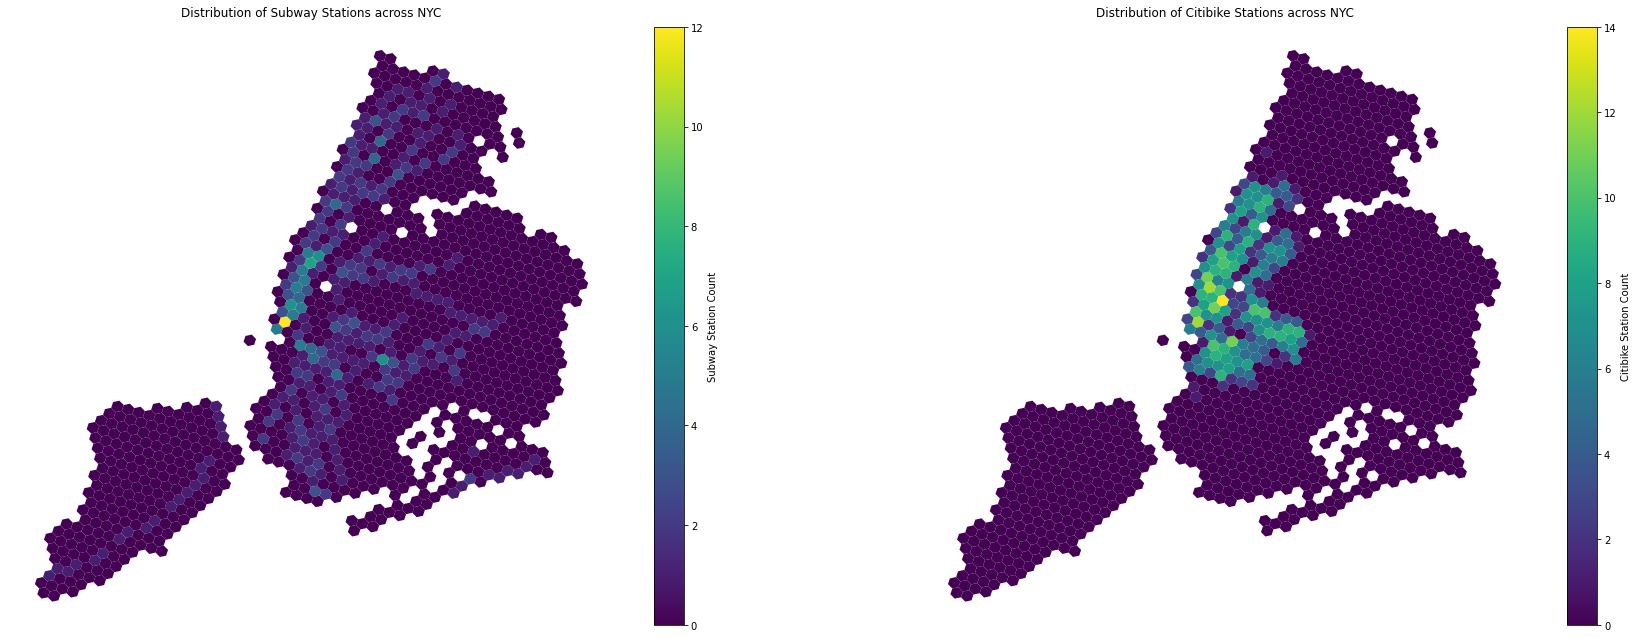

In [30]:
fig, ax = plt.subplots(1,2,figsize=(30,40))

ax[0].axis('off')
ax[0].set_title('Distribution of Subway Stations across NYC');

ax[1].axis('off')
ax[1].set_title('Distribution of Citibike Stations across NYC');

subway_gdf.plot(ax          = ax[0],
                column      ='subway_station_count',
                legend      = True,
                legend_kwds = {'label': 'Subway Station Count',
                               'orientation': 'vertical',
                               'shrink': 0.275})

bike_gdf.plot(ax          = ax[1],
              column      = 'bike_station_count',
              legend      = True,
              legend_kwds = {'label': 'Citibike Station Count',
                             'orientation': 'vertical',
                             'shrink': 0.275});

In [5]:
subway_gdf.merge(bike_gdf).to_file("../data/shapefiles/nyc/station_counts.geojson",
                                   driver='GeoJSON')